In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm

data = pd.read_csv('~/Downloads/data.csv')
fp = fm.FontProperties(fname='/Library/Fonts/Yu Gothic Medium.otf', size=12)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
N     100 non-null int64
y     100 non-null int64
x     100 non-null int64
id    100 non-null int64
dtypes: int64(4)
memory usage: 3.2 KB


In [3]:
data.describe()

,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


/Users/yusuke-nishioka/.anyenv/envs/pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


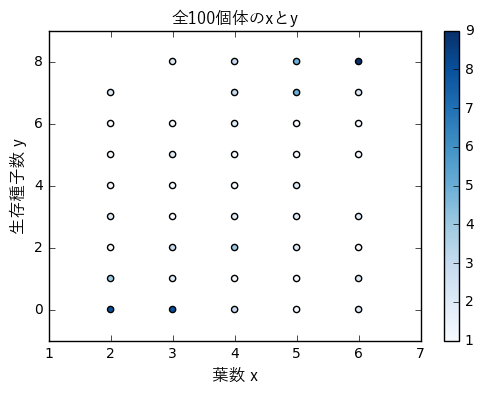

In [31]:
data_for_plot = data.groupby(['x', 'y']).size().reset_index().rename(columns={0: 'num'})
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# http://matplotlib.org/examples/color/colormaps_reference.html
fig.colorbar(ax.scatter(data_for_plot.x, data_for_plot.y, c=data_for_plot.num, cmap=cm.Blues))
ax.set_xlabel('葉数 x', fontproperties=fp)
ax.set_ylabel('生存種子数 y', fontproperties=fp)
ax.set_title('全100個体のxとy', fontproperties=fp)
fig.show()

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.glm(formula='y + I(N - y) ~ x', data=data,
              family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Thu, 05 Jan 2017   Deviance:                       513.84
Time:                        08:19:59   Pearson chi2:                     428.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000        -2.614    -1.684
x              0.5104      0.056      9.179      0.000         0.401     0.619
==============================================================================
"""

/Users/yusuke-nishioka/.anyenv/envs/pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


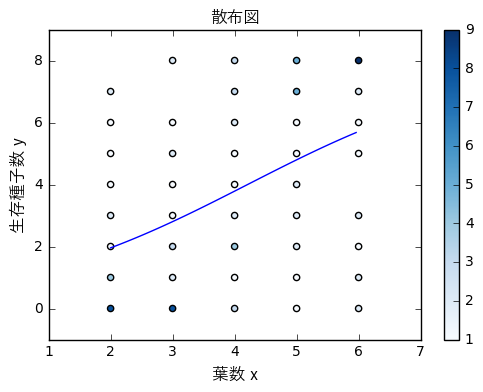

In [5]:
N = 8
xrange = np.arange(min(data.x), max(data.x), (max(data.x) - min(data.x)) / 100)
x_test = pd.DataFrame({'x': xrange})
y_test = res.predict(x_test)

fig.show()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.colorbar(ax.scatter(data_for_plot.x, data_for_plot.y, c=data_for_plot.num, cmap=cm.Blues))
ax.plot(x_test, y_test * N, label='C')
ax.set_xlabel('葉数 x', fontproperties=fp)
ax.set_ylabel('生存種子数 y', fontproperties=fp)
ax.set_title('葉数と生存種子数の関係', fontproperties=fp)
fig.show()

/Users/yusuke-nishioka/.anyenv/envs/pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


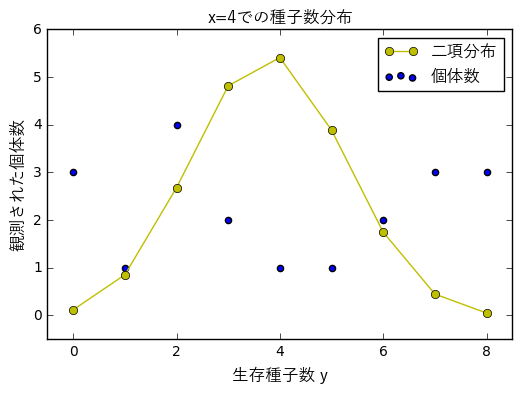

In [30]:
def nCr(n,r):
    f = np.math.factorial
    return f(n) / f(r) / f(n-r)

p = res.predict(pd.DataFrame({'x': [4]}))[0]
bin_plot = np.array([nCr(N, i) * (p**i) * ((1-p)**(N-i)) for i in range(0, N+1)])

fig.show()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data_for_plot.y[data_for_plot.x==4], data_for_plot.num[data_for_plot.x==4],
           label='個体数')
ax.plot(data_for_plot.y[data_for_plot.x==4],
        bin_plot * sum(data_for_plot.num[data_for_plot.x==4]),
        '-o', color='y', label='二項分布')
ax.set_xlabel('生存種子数 y', fontproperties=fp)
ax.set_xlim(-0.5, 8.5)
ax.set_ylabel('観測された個体数', fontproperties=fp)
ax.set_ylim(-0.5)
ax.set_title('x=4での種子数分布', fontproperties=fp)
ax.legend(loc='best', fontsize=10, prop=fp)
fig.show()

In [7]:
from statsmodels.genmod.generalized_estimating_equations import GEE

# http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/lc6uf6dmabmitjbup3yt.ipynb 
# http://stats.stackexchange.com/questions/206452/standard-error-differences-binomial-regression-vs-poisson-regression
# https://groups.google.com/forum/#!searchin/pystatsmodels/GEE$20binomial%7Csort:relevance/pystatsmodels/6wxIsDmaeY8/FReXGyF9kRUJ
#gee = GEE.from_formula('y + I(N-y) ~ x', data=data, groups=data.id, family=sm.families.Binomial())
#ar = sm.cov_struct.Autoregressive()
ar = sm.cov_struct.Exchangeable()
gee = smf.gee('y + I(N-y) ~ x', 'id', data=data, cov_struct=ar, family=sm.families.Binomial())
res = gee.fit()
print(res.summary())

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (2,2)